[![session-9](https://github.com/jorge1b3/Hands-on-Computer-Vision/blob/main/Sesiones/Sesion9/Sesion9-banner.png?raw=1)](https://github.com/semilleroCV/Hands-on-Computer-Vision/tree/main/Sesiones/Sesion9)

In [1]:
#@title **load required libraries**
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%%capture
#@title clone our repo to get data 'locally'
! git clone -n --depth=1 --filter=tree:0 \
  https://github.com/semilleroCV/Hands-on-Computer-Vision
%cd Hands-on-Computer-Vision
! git sparse-checkout set --no-cone Sesiones/Sesion9
! git checkout
%cd Sesiones/Sesion9/

# <font color="EB9A54"><center> **Hands-On Sesión 9: Pre-Thermal Imaging 📚🌡️** </center></font>

## <font color='#4C5FDA'> **Contenido**</font>

[**1. Cargamos los datos de una zona**](#tema1)

[**2. Generar la imagen térmica**](#tema2)

[**3. Generar atenuación**](#tema3)

[**4. Intensidad de la escena**](#tema4)

[**5. Lectura del sensor**](#tema5)

# <font color="4C5FDA"> **Cargamos los datos de una zona** </font><a name="tema1"></a>

Primero cargaremos un mapa de profundidad de una zona que fue tomado desde una perspectiva superior. En este mapa de profundidad, las distancias son relativas al suelo (lo que sale azúl).

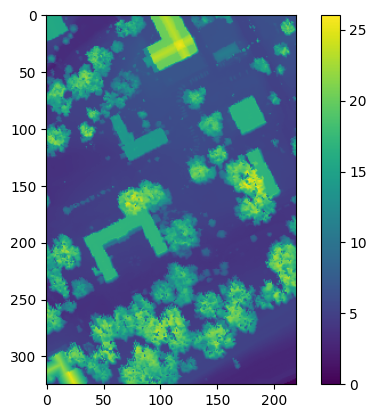

In [3]:
depth_map = loadmat('data/Depth.mat')["depth"]
plt.imshow(depth_map)
plt.colorbar()
plt.show()

Luego cargamos las etiquetas de los materiales para asignarles temperatura de manera sintética.
<div align=center><img src = 'https://github.com/GatorSense/MUUFLGulfport/raw/master/MUUFLGulfportSceneLabels/muufl_scene_labels_screenshot.png' height='400'></div>

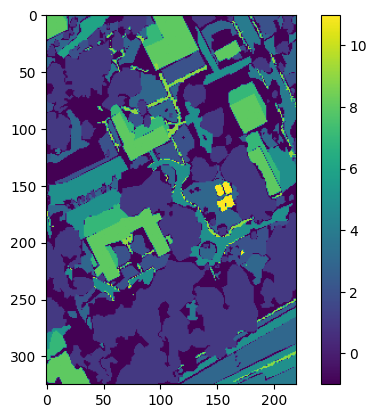

In [4]:
labels = loadmat('data/Labels.mat')["labels"]
plt.imshow(labels)
plt.colorbar()
plt.show()

In [5]:
print(f'Tenemos {len(np.unique(labels))} etiquetas que son: {np.unique(labels)}.')

Tenemos 12 etiquetas que son: [-1  1  2  3  4  5  6  7  8  9 10 11].


La siguiente `Data` son los valores de **emisividad** para una imagen **hiperespectral**, en total 64 canales. Lo que se ve en la imagen es el valor de **emisividad** en un píxel determinado a través de los 64 canales.

Mira la **emisividad** en cualquier punto de la imagen y cuestiona ¿por qué no todos los canales miden la misma **emisividad**?

(325, 220, 64)


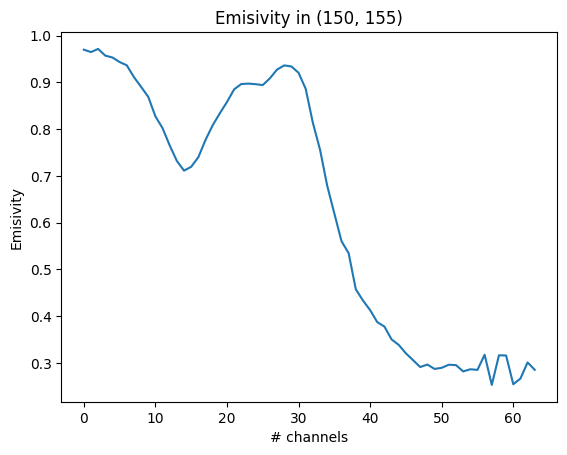

In [8]:
pixel_x = 150
pixel_y = 155

Data = loadmat('data/Data.mat')["data"]
Data[Data<0] = 0
# en realidad, los datos que vienen son de transmitancia, pero si recuerdas del
# notebook anterior, 1 - τ = ε
Data = 1 - Data

print(Data.shape)
plt.plot(Data[pixel_x,pixel_y,:])
plt.title(f'Emisivity in ({pixel_x}, {pixel_y})')
plt.xlabel('# channels')
plt.ylabel('Emisivity')
plt.show()

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">1</font>** 💪</font>

Cambie la profundidad del depth map. **Nota**: Tenga en cuenta que el depthmap se realiza relativo al suelo.

In [9]:
def changeDepth(depth_map, altura):
  new_depth_map = np.zeros((depth_map.shape[0],depth_map.shape[1], 1))
  new_depth_map[:,:,0] = altura-depth_map
  return new_depth_map

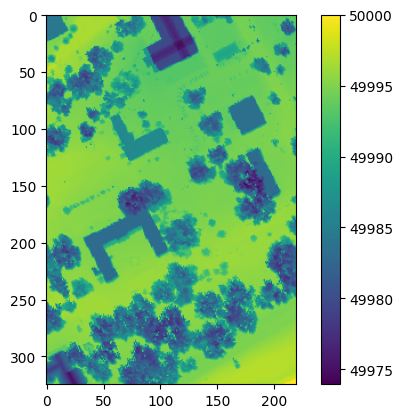

In [14]:
new_depth_map = changeDepth(depth_map, 50000)
plt.imshow(new_depth_map)
plt.colorbar()
plt.show()

# <font color="4C5FDA"> **Generar la imagen térmica** </font><a name="tema2"></a>

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">2</font>** 💪</font>

Genera el mapa de temperatura a partir de la imagen etiquetada.

1. Genera un diccionario de Python que mapee las etiquetas de los materiales con una temperatura en grados Kelvin.

In [18]:
start_temperature = 300 # Temperatura inicial en Kelvin.
end_temperature = 350 # Temperatura final en Kelvin.
temp_values = np.linspace(start_temperature, end_temperature, 12) # Valores de temperatura. Recuerda que son 12 labels.
keys = np.unique(labels) # Labels unicos de la imagen.
labels_dictionary = dict(zip(keys, temp_values)) #Diccionario con la temperatura de cada label.

2. Ejecuta la siguiente celda para crear la imagen térmica o mapa de temperatura.

In [19]:
map_func = np.vectorize(lambda x: labels_dictionary.get(x))
image_temperature = np.zeros((labels.shape[0],labels.shape[1],1)) # Creamos una imagen 'falsa' para llenarla de valores
image_temperature[:,:,0] = map_func(labels) # Rellenamos esa imagen con nuestro diccionario

**Nota:** De momento, solo le estamos asignando una temperatura a cada píxel, en un solo canal, según las etiquetas que teníamos.

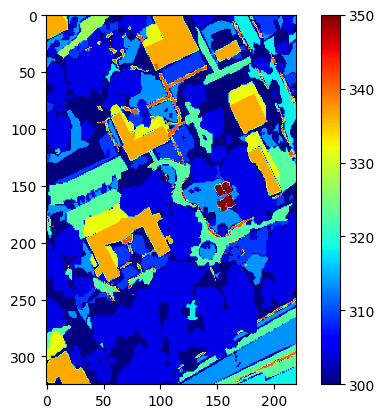

In [21]:
plt.imshow(image_temperature[:,:,0], cmap='jet')
plt.colorbar()
plt.show()

# <font color="4C5FDA"> **Generar atenuación** </font><a name="tema3"></a>

Las ondas de luz que emiten los objetos en una escena son **atenuadas** por el aire. El siguiente código, carga unos datos que tienen la 'cantidad' que **atenua** el aire en varias longitudes de onda.

In [22]:
def get_attenuation(lambda_start, lambda_stop):

  """
  Esta función nos entrega las longitudes de onda con su valor de
  atenuación en un rango del espectro determinado (lambda_start a lambda_stop)
  """

  trans_array = np.loadtxt('data/transmittance_atten_1mAir.txt')

  # Tomar indices
  start_index = np.where(trans_array[:,0] == lambda_start)[0]
  stop_index = np.where(trans_array[:,0] == lambda_stop )[0]
  trans_index = np.arange(start_index, stop_index)

  # Extraer las longitudes de onda y la atenuación del vector
  wavelength = trans_array[trans_index,0]
  attenuation = trans_array[trans_index,2]

  # Reducimos todas los datos en ese rango a solo 64, debido a que nuestra imagen
  # solo trae 64 canales.
  wavelength = wavelength[np.linspace(0 ,len(wavelength) - 1, 64, dtype=int)]
  attenuation = attenuation[np.linspace(0 ,len(wavelength) - 1, 64, dtype=int)]

  return wavelength, attenuation

<ipython-input-22-5ff2e69ca72d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trans_index = np.arange(start_index, stop_index)


The attenuation vector has 64 samples


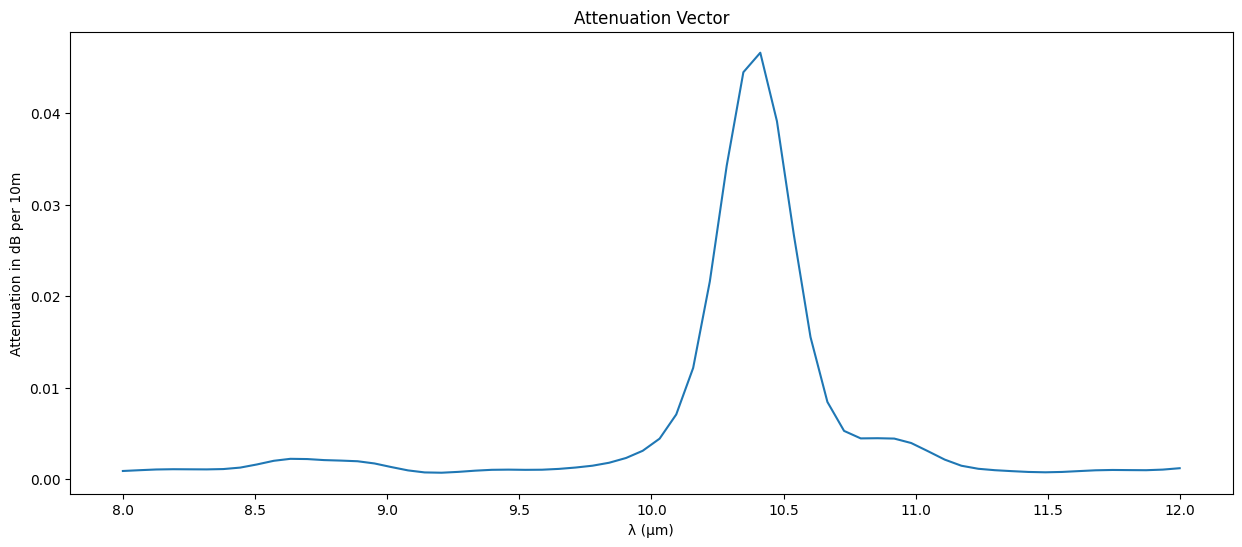

In [23]:
#Ajustando los parametros del problema

lambda_start = 8 # Lambda se encuentra en micrometros
lambda_stop= 12 # Lambda se encuentra en micrometros

wavelength, attenuation  = get_attenuation(lambda_start, lambda_stop)
print(f'The attenuation vector has {attenuation.shape[0]} samples')

plt.figure(figsize=(15,6))
plt.plot(wavelength, attenuation)
plt.title('Attenuation Vector')
plt.xlabel('λ (μm)')
plt.ylabel('Attenuation in dB per 10m')
plt.show()

# <font color="4C5FDA"> **Intensidad de la escena** </font><a name="tema4"></a>

Ahora que tenemos los datos (`Data`) de **intensidad** para una imagen en 64 canales y además lo que **atenua** el aire en esos 64 canales podemos determinar la intensidad teórica que **emite** un determinado pixel en una escena.

Pero una cosa... Si el aire **atenua** las ondas de la escena, eso significa que está **absorbiendo** y si **absorbe** energía la tiene que **emitir**.

$$
L_{\text {air }}(\lambda)=(1-\tau(\lambda)) B\left(\lambda ; T_{\text {air }}\right)
$$

Básicamente, la intensidad teórica que **emite** un objeto será lo que **emite** el objeto en sí sumado con lo que **emite el aire**:

$$
L_{\mathrm{obs}}(\lambda)=L_{\mathrm{obj}}(\lambda)+L_{\mathrm{air}}(\lambda)
$$

Y lo que emite el objeto es lo siguiente:

$$
L_{\mathrm{obj}}(\lambda) = \tau(\lambda) E(\lambda) B(\lambda ; T_{scene})
$$

La **transmitancia** viene dada por:

$$
\tau(\lambda ; d)=10^{-\alpha(\lambda) d / 10}
$$

donde $\alpha(\lambda)$ es el coeficiente de **atenuación** en función de la longitud de onda, en unidades de dB/m.

Reemplazando y factorizando $\tau(\lambda)$ podemos calcular la intensidad de la escena:

$$
I( \vec{x}, \lambda) = 10^{-attenuation(\lambda)d(\vec{x})/10}[E(\vec{x}, \lambda) L(\vec{x},T_{scene}, \lambda) - L(\vec{x}, T_{air}, \lambda)] + L(\vec{x}, T_{air}, \lambda)
$$

Donde $E(\vec{x},\lambda)$ representa la emisividad del pixel en un canal. $L(\vec{x},T, \lambda)$ son los fotones por segundo emitidos por un cuerpo negro a una determinada temperatura. Aquí asumimos que la radiación que llega a cada pixel es producida por **un solo objeto** (y el aire).

In [24]:
from scipy.constants import h, c, k

# h: Constante de Planck
# c: Velocidad de la luz en el vacío
# k: Constante de Boltzmann

def blackbody(wavelength, T):

  """
  La siguiente función es la ecuación del cuerpo negro
  convirtiendo las unidades a fotones por segundo.

  Esta es la versión en términos de la frecuencia.
  """

  Dlambda = wavelength[1] - wavelength[0]

  Nu = (c*1e6)/wavelength
  DNu = (c*1e6)/(wavelength - Dlambda/2) - (c*1e6)/(wavelength + Dlambda/2)

  Intensity = ( (2*h*Nu**3)/(c**2) ) / (np.exp((h*Nu)/(k*T))-1)
  PhotPerSec = Intensity*(wavelength*1e-6)*DNu/(h*c)
  return PhotPerSec

In [25]:
def propagate(lambda_start, lambda_stop, T_air, depth, T_scene, emissivity):

  """
  Esta función simula la propagación  la luz que llega a la apertura
  de una cámara térmica que emite una escena.

  propagación de la luz emitidad por una escena a través de la atmosfera
  """

  wavelength, attenuation = get_attenuation(lambda_start, lambda_stop)

  # Calcular la radiación de los cuerpos negros en fotones por segundo
  L_air = blackbody(wavelength, T_air)
  L_scene = blackbody(wavelength, T_scene)

  alpha = 10**(-attenuation*depth/10)

  # Calcular la luz en la apertura basado en el modelo anterior
  light_on_aperture = alpha*(emissivity*L_scene - L_air) + L_air

  return light_on_aperture

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">3</font>** 💪</font>  

Asigna una temperatura al ambiente, calcula la intensidad y grafique las dos curvas envolventes de un pixel.

**Nota**: Tenga en cuenta los parámetros de la funciones `propagate` y `blackbody`.

<ipython-input-22-5ff2e69ca72d>:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trans_index = np.arange(start_index, stop_index)


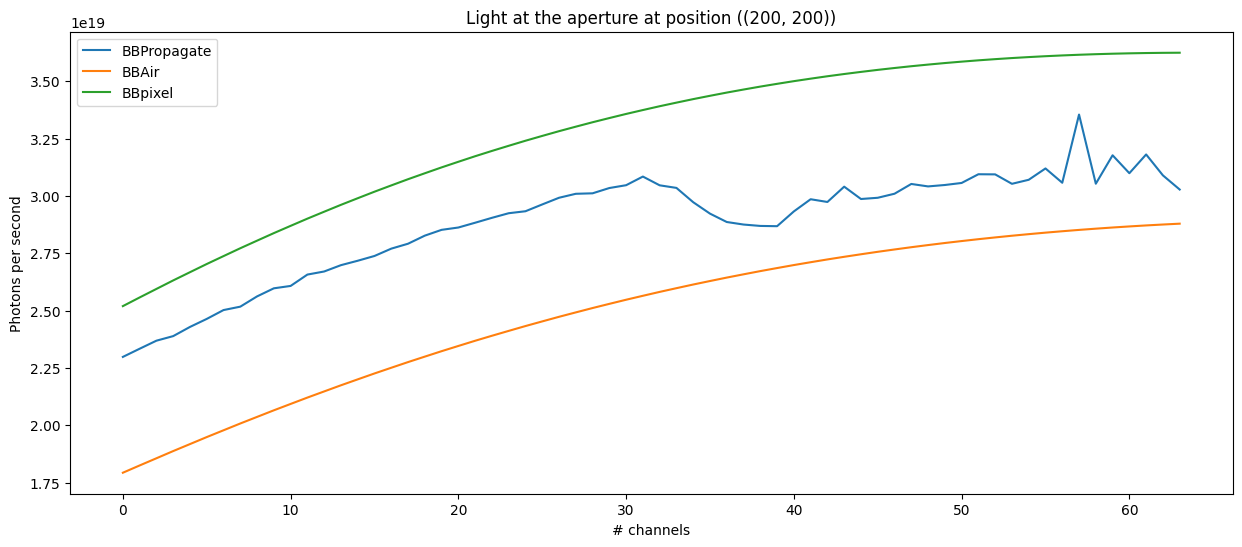

In [29]:
pixel_x = 200
pixel_y = 200

T_air = 288
I = propagate(lambda_start, lambda_stop, T_air, 50, 300,Data )

blackbody_air = blackbody(wavelength, T_air)
blackbody_obs = blackbody(wavelength, image_temperature[pixel_x, pixel_y, 0]) # Estamos tomando la temperatura de un solo pixel

plt.figure(figsize=(15,6))
plt.title(f'Light at the aperture at position ({pixel_x, pixel_y})')
plt.plot(I[pixel_x, pixel_y, :])
plt.plot(blackbody_air)
plt.plot(blackbody_obs)
plt.legend(['BBPropagate','BBAir','BBpixel'])
plt.xlabel('# channels')
plt.ylabel('Photons per second')
plt.show()

# <font color="4C5FDA"> **Lectura del sensor** </font><a name="tema5"></a>

Las lecturas de nuestro sensor se describen de la siguiente manera:

\begin{align}
Y_i &= X_i + Z_i \\
X_i &\sim poisson(\eta_i) \\
Z_i &\sim N(0,\sigma^2)
\end{align}

donde

$$\eta_i = A \cdot \pi \cdot {\text{NA}}^2 \cdot t_{dwell} \int_{\vec{x} \in A_{sensor}} \int_{\lambda^{lower}_i}^{\lambda^{upper}_i} I(\vec{x}, \lambda) d\lambda d\vec{x}$$
$A_{sensor}$ es el area del sensor, $I(\vec{x}, \lambda)$ es la intensidad en terminos de fotones por segundo y $\sigma$ es la desviación estandar del ruido de lectura.

In [30]:
def get_rates(I, channel_efficiency = 1, f_number = 2.9, A = (1e-5)**2, t_dwell = 1e-6):
  NA = 1/(2*f_number)
  Omega = np.pi*(NA**2)
  sensor_params = t_dwell * A * Omega * channel_efficiency
  return I*sensor_params

In [31]:
def detect(eta, readout_noise = 0):
  y = np.random.poisson(eta) + np.random.normal(0, readout_noise, size = eta.shape)
  return y

## <font color='#ECA702'>**<font color="#FF0000">R</font><font color="#FF7F00">e</font><font color="#FFFF00">t</font><font color="#00FF00">o</font> #<font color="#0000FF">4</font>** 💪</font>

1. Juega con el ruido y parámetros del sensor, encuentra la toma esperada y la real.
2. Calcula los errores (RMSE Y MAE) entre las intensidades teóricas y las detectadas.

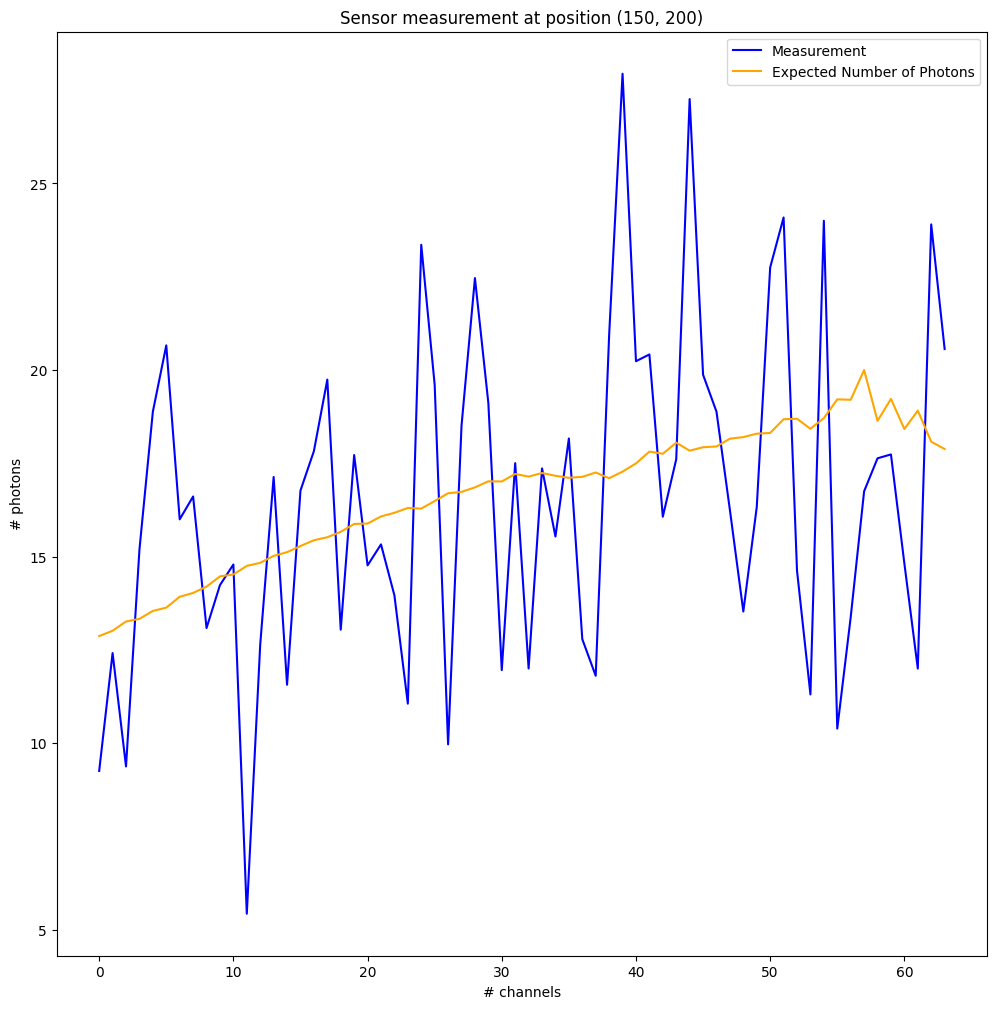

In [34]:
# eta = get_rates(I, channel_efficiency = None, f_number = None, A = None, t_dwell = None) # Toma esperada
eta = get_rates(I, channel_efficiency=0.5, f_number=8, A=(1e-5)**2, t_dwell = 1e-6) # Toma esperada
y = detect(eta, readout_noise = 0.5) # Toma 'real'

pixel_y = 200
pixel_x = 150

plt.figure(figsize = [12,12])
plt.title(f'Sensor measurement at position {pixel_x, pixel_y}')
plt.plot(y[pixel_x, pixel_y, :], color='blue')
plt.plot(eta[pixel_x, pixel_y, :], color='orange')
plt.legend(['Measurement','Expected Number of Photons'])
plt.xlabel('# channels')
plt.ylabel('# photons')
plt.show()

En la siguiente celda lo que hacemos es sumar todos los canales en uno solo. Para no tener desbordamientos en los valores, antes normalizamos entre 0 y 1 al dividir cada pixel por el pixel con el valor máximo de todos los canales.

RMSE: 8496.837615314953
MAE: 14468276.532786012


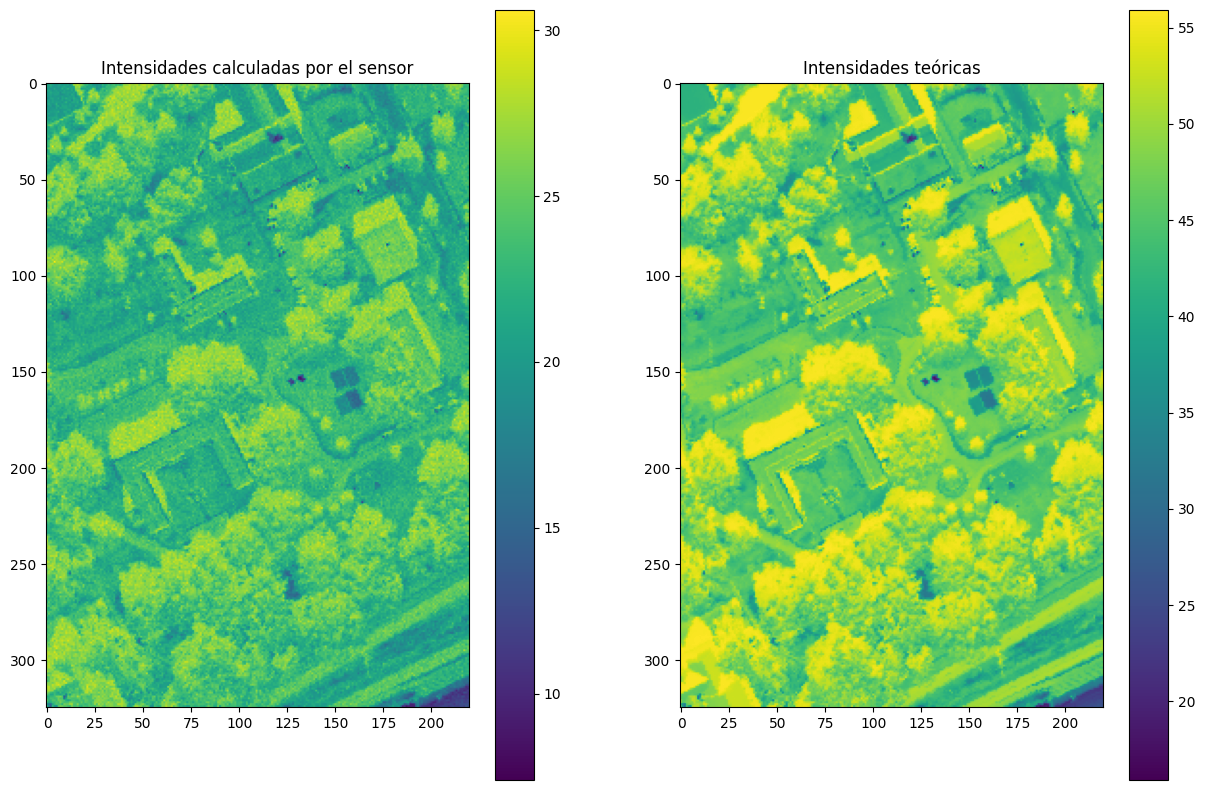

In [35]:
new_image = np.sum(y/y.max(), axis=2) # toma 'real'
reference = np.sum(I/I.max(), axis=2) # toma esperada

# Calcula el RMSE
rmse = np.sqrt(np.sum((eta - y) ** 2))

# Calcula el MAE
mae = np.sum(np.abs(eta - y))

# Imprime los errores
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

plt.figure(figsize=(15, 10))
plt.subplot(121),plt.imshow(new_image), plt.colorbar(), plt.title("Intensidades calculadas por el sensor")
plt.subplot(122),plt.imshow(reference), plt.colorbar(), plt.title("Intensidades teóricas")
plt.show()